# DS-GA 1019

# Lab 7 - Review
## Mar. 9, 2023

Iterative algorithm to calculate nth fibonacci number. Time complexity: O(N)

In [3]:
def fib_iter(n):
    a,b = 0,1
    if n<=1:
        return n
    
    for i in range(2,n+1):
        a,b = b,a+b
    return b

### Can we do better?

Our recurrence relation is:
    f(n) = f(n-1) + f(n-2)
    
It can be expressed as matrix multiplication

$$
    \begin{pmatrix} f(n+1)  \\ f(n) \end{pmatrix} = \begin{pmatrix} a & b \\ c & d \end{pmatrix} *                                                                  \begin{pmatrix} f(n)  \\ f(n-1) \end{pmatrix} \\
$$
 

$$
    f(n+1) = a.f(n) + b.f(n-1) \\ 
    f(n) = c.f(n) + d.f(n-1) 
$$

a=1, b=1, c=1, d=0 will satisfy the system of equations

$$
    \begin{pmatrix} f(n+1)  \\ f(n) \end{pmatrix} = \begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix} *                                                                  \begin{pmatrix} f(n)  \\ f(n-1) \end{pmatrix} \\
$$
$$
     \qquad\qquad  = \begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix}^n *                                                                  \begin{pmatrix} f(1)  \\ f(0) \end{pmatrix} \\
$$

Information on Recurrence relations and matrix multiplication - https://comeoncodeon.wordpress.com/2011/05/08/recurrence-relation-and-matrix-exponentiation/

### Matrix exponentiation in log(n)

In [1]:
import numpy as np
def fib_matmul(n):
    M = np.array([[1,1],[1,0]]).astype(object)
    
    M_pow = np.linalg.matrix_power(M,n)
    
    initial_values = np.array([1,0])
    
    ans = np.matmul(M_pow, initial_values)[1]

    return ans



In [4]:
from statistics import mean

times_matmul = []
times_iter = []

for i in range(1,10000,10):
    
    t1 = %timeit -o -n 1 -q fib_matmul(i)
    times_matmul.append(mean(t1.all_runs))

    t2 = %timeit -o -n 1 -q fib_iter(i)
    times_iter.append(mean(t2.all_runs))


In [5]:
import matplotlib.pyplot as plt

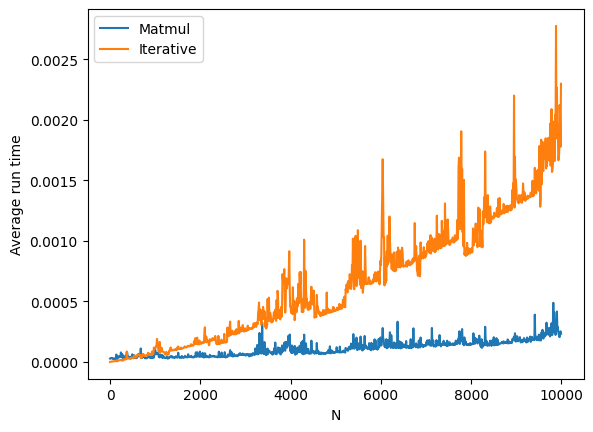

In [6]:
x = np.arange(1,10000,10)
plt.plot(x,times_matmul,label = 'Matmul')
plt.plot(x, times_iter,label = 'Iterative')
plt.xlabel('N')
plt.ylabel('Average run time')
plt.legend()
plt.show()

### Pairwise distance: Numba vs cython vs numpy

This function will take an array representing N points in m dimensions, and return the N x N matrix of pairwise distances.

In [7]:
X = np.random.random((1000, 3))

#### Numpy Function With Broadcasting

We can use numpy's broadcasting and vectorization to calculate the pairwise distance matrix D where

```D[i,j] = distance(X[i], X[j])```

if X is the array of points, shape of X would be (N,m)

```X[None, :]``` will be of shape (1,N,m)

```X[:,None]``` will be of shape (N,1,m)

We obtain the pairwise difference ```D =  X[None,:] - X[:,None]```

We want to end up with an NxN matrix, so we sum over the axis with dimension m. This is axis = -1, since it is the first axis from the end

```np.sum((X[None, :] - X[:, None])**2, -1)```

Information on Numpy broadcasting rules - https://numpy.org/doc/stable/user/basics.broadcasting.html

In [16]:
x = np.array([[1,2,3],[3,3,3]])
print(x.shape)
print(x[:,:,None].shape)
print(x[None,:].shape)
print(x[:,None].shape)
x[None,:]+x[:,None]      # pairwise addition

(2, 3)
(2, 3, 1)
(1, 2, 3)
(2, 1, 3)


array([[[2, 4, 6],
        [4, 5, 6]],

       [[4, 5, 6],
        [6, 6, 6]]])

In [34]:
def pairwise_numpy(X):
    return np.sqrt(np.sum((X[None, :] - X[:, None])**2, -1))

time_np = %timeit -o  pairwise_numpy(X)


8.98 µs ± 654 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Pure Python Function

In [35]:
def pairwise_python(X):
    N = X.shape[0]
    m = X.shape[1]
    D = np.empty((N, N), dtype=np.float)
    for i in range(N):
        for j in range(N):
            d = 0.0
            for k in range(m):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

time_py = %timeit -o -n 1 pairwise_python(X)

The slowest run took 8.10 times longer than the fastest. This could mean that an intermediate result is being cached.
334 µs ± 328 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


/tmp/ipykernel_414/3776343407.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  D = np.empty((N, N), dtype=np.float)


### Numba Wrapper

In [36]:
from numba import double,jit

@jit(nopython=True)
def pairwise_numba(X):
    N = X.shape[0]
    m = X.shape[1]
    D = np.empty((N, N), dtype=double)
    for i in range(N):
        for j in range(N):
            d = 0.0
            for k in range(m):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

time_nb = %timeit -o pairwise_numba(X)

The slowest run took 18.78 times longer than the fastest. This could mean that an intermediate result is being cached.
4.69 µs ± 7.99 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba with parallelism

In [63]:
from numba import prange

@jit(nopython=True,parallel=True)
def pairwise_numba_parallel(X):
    N = X.shape[0]
    m = X.shape[1]
    D = np.empty((N, N), dtype=double)
    for i in prange(N):
        for j in prange(N):
            d = 0.0
            for k in prange(m):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

time_nb_par = %timeit -o pairwise_numba_parallel(X)

The slowest run took 15.21 times longer than the fastest. This could mean that an intermediate result is being cached.
22.6 µs ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba with fast math

In [38]:
@jit(nopython=True, parallel=True, fastmath=True)
def pairwise_numba_parallel_quickmaths(X):
    N = X.shape[0]
    m = X.shape[1]
    D = np.empty((N, N), dtype=double)
    for i in prange(N):
        for j in prange(N):
            d = 0.0
            for k in prange(m):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

time_numba_fastmath = %timeit -o pairwise_numba_parallel_quickmaths(X)

The slowest run took 20.76 times longer than the fastest. This could mean that an intermediate result is being cached.
44.6 µs ± 56.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Cython Function

In [39]:
%load_ext cython

In [40]:
%%cython
import numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
def pairwise_cython(double[:, :] X):
    cdef int N = X.shape[0]
    cdef int m = X.shape[1]
    cdef double tmp, d
    cdef double[:, :] D = np.empty((N, N), dtype=np.float64)
    for i in range(N):
        for j in range(N):
            d = 0.0
            for k in range(m):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = sqrt(d)
    return np.asarray(D)


In [41]:
time_cy = %timeit -o pairwise_cython(X)

1.95 µs ± 105 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [42]:
from scipy.spatial.distance import cdist
time_sp = %timeit -o cdist(X, X)

4.24 µs ± 370 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


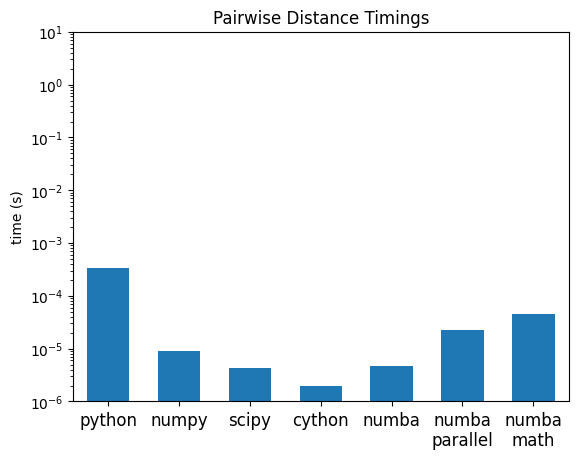

In [64]:
labels = ['python', 'numpy',  'scipy', 'cython', 'numba','numba\nparallel','numba\nmath']
timings = [time_py, time_np, time_sp, time_cy, time_nb,time_nb_par,time_numba_fastmath]
timings = [mean(t.all_runs)/t.loops for t in timings]

x = np.arange(len(labels))
plt.axes(xticks=x, yscale='log')
plt.bar(x , timings, width=0.6)

plt.xlim(-0.5, len(labels) - 0.5)
plt.ylim(1E-6, 1E1)
plt.xticks(range(len(labels)),labels,size=12)
plt.ylabel('time (s)')
plt.title("Pairwise Distance Timings")
plt.show()


In [48]:
import numpy as np
from numba import cuda


@cuda.jit
def distance_matrix(mat, out):
    n = mat.shape[0]
    m = mat.shape[1]
    i, j = cuda.grid(2)
    d = 0
    if i < n and j < n:
        for k in range(m):
            tmp = mat[i, k] - mat[j, k]
            d += tmp * tmp
        out[i, j] = d

def pairwise_numba_gpu(mat):
    rows = mat.shape[0]

    block_dim = (16, 16)
    grid_dim = (int(rows/block_dim[0] + 1), int(rows/block_dim[1] + 1))

    mat2 = cuda.to_device(mat)
    out2 = cuda.device_array((rows, rows))
    distance_matrix[grid_dim, block_dim](mat2, out2)
    out = out2.copy_to_host()

    return out


In [49]:
%timeit pairwise_numba_gpu(X)

The slowest run took 46.97 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 3.59 ms per loop


#### Why is the GPU slower than the CPU

- Our inputs are too small: We need larger arrays to keep the GPU occupied
- Copying data from and to the GPU 

In [50]:
X = np.random.random((1024,256))

In [51]:
%timeit pairwise_numba_gpu(X)

10 loops, best of 5: 12.7 ms per loop


In [52]:
%timeit pairwise_numba_parallel(X)

10 loops, best of 5: 181 ms per loop
